# The problem of binary similarity

The problem of binary similarity consists of determining if two pieces of binary software are compiled starting from the same source code and it can be addressed at different levels of analysis: basic blocks, functions or whole binary.  Binary similarity is a problem of interest in many software analysis fields: plagiarism detection, malware detection/classification, vulnerability detection.

Due to the high number of modifications performed by the compiler during the compilation phase, binary similarity is far from being a trivial operation. Indeed, if the same source code is compiled using two different compilers, it is likely that the two produced binaries are different.

In this work we analyze binaries at function level, exploring the function binary similarity problem. In particular, we are interested in checking if a model for function binary similarity trained only on benign software can give enough information at program level helping to distinguish between APT malware belonging to different APT groups.

## Current solutions

Solutions for function binary similarity can be essentially distinguished in the ones that use deep neural-networks [1, 2, 3] and the ones that do not [4, 5, 6]. Most recent solutions all propose approaches based on DNNs, since they shown state-of-the-are performance with low computational effort.

Loosely speaking, deep learning models for function binary similarity trasform the input into a fixed-size vector of real values, called embedding, which can than be easily used for comparison. Indeed, functions can be represented into a vector space through their embeddings, which can then be compared using a distance function such as cosine similarity. Ideally, functions with a similar semantic are represented through embedding vectors that are close in the embedding space. Such solutions differ in the feature extraction process.

We can distinguish between models using manual feature extraction and models that learn features automatically during the training process. In the first case, features are usually extracted from alternative representations of binary code (such as the control flow graph or the abstract syntax tree) since they carry some useful information about the semantic and the syntax of the input. In the latter, an embedding model (i.e., word2vec, glove, fasttext) is used for learning an embedding representation of assembly instructions. Then, such instruction embeddings are aggregated into the final function embedding vector. Ideally, instructions with a similar semantic are close in the embedding space.

## Gemini

Gemini [2] is a neural network-based solution for generating binary functions embeddings starting from the ACFG (Attributed Control Flow Graph) representation of the input binary function; such structure is converted into an embedding vector using a Graph Embedding Network based on the Structure2Vec model.
Each vertex of the ACFG consists of a numeric feature vector associated to the corresponding basic block in the CFG of the binary function. For each basic block the following features are extracted:
1. number of constants;
2. number of strings;
3. number of transfer instructions (e.g., MOV);
4. number of calls;
5. number of instructions;
6. number of arithmetic instructions (e.g., ADD);
7. vertex off-springs;
8. vertex betweenness centrality.

The first six features are related to the binary code of the block while the last two depends on the structure of the CFG.

Once generated a feature vector for each vertex of the CFG, they are aggregated using a graph neural network based on Structure2Vec. Here, vertex features are aggregated recursively according to graph topology; indeed, after a predetermined number of recursion steps, for each vertex the network produces a new feature vector considering both graph topology and interactions between vertex features. For each vertex, the embedding vectors are initialized at 0 and updated during each iteration using a non-linear propagation function. The parameters of such function are learned during the training process.

The whole architecture is trained using a pairwise approach called Siamese network, which consists of two identical GNNs (sharing the same set of parameters) that are joined at the top using a distance function (i.e., the cosine similarity). Each GNN takes in input an ACFG and outputs its embedding, with the final output of the siamese network being the cosine distance between the two produced embeddings. The key point of this training process is that the learned parameters are suited to specifically address the problem of function binary similarity instead of pure classification.

Gemini is trained using a set of 95535 graphs generated from the binaries contained in two OpenSSL versions (v1_0_1f - v_10_lu), compiled on x86 and ARM architectures using gcc5.4 with 4 optimization levels.

# APT classification

Classify APT malwares according to their group provenance is an interesting task to investigate. Think about analysing an APT without having information about its provenance; if we were able to trace the APT back to a known group then the analysis would be easier. So, instruments like the models introduced before could help find APTs that are semantically similar to a given one; in this way, we can infer information about the unknown APT from the malware previously analyzed and belonging to its same group.

## Gemini for program binary similarity

### Program representation

As described before, Gemini is a DNN-based model for producing embeddings of binary functions. This means that we cannot obtain a direct representation of a malware, so an entire binary program, using such model. Nevertheless we can directly measure the similarity between two binary programs.

A program $P_j$ composed by $n_j$ binary functions, can be described by the set of its binary functions embeddings, so:

$$
P_j = \{\vec{f_0}, \vec{f_1}, ..., \vec{f_{n_j}}\}
$$

At this point we can define the similarity between two programs as a function of how many of the binary functions composing them are similar, using the embeddings produced by Gemini to calculate function binary similarity.

Given a binary function $\vec{f}$ and the program $P_j$ defined as before, we can define the following function indicating whether $P_j$ contains the function $\vec{f}$:

\begin{equation}
  \alpha(\vec{f}, P_j) =
    \begin{cases}
      1 & \text{if $\exists$ $\vec{f_x} \in P_j$ s.t. $\vec{f} \cdot \vec{f_x} > \tau$}\\
      0 & \text{else}
    \end{cases}
\end{equation}

where $\tau$ is the similarity threshold and it is equal to 0.95.

At this point we can define the similarity between two programs $P_i$ and $P_j$ as:

$$
S(P_i, P_j) = \frac{\sum_{\forall \vec{f} \in P_i} \alpha(\vec{f}, P_j)}{max(|P_i|, |P_j|)}.
$$

### Classify Programs

Given a similarity measure as the one introduced before, we can use similarity-based classifiers [2] to estimate the group of a given APT sample based on the similarity between the given APT sample and a set of labeled training APT samples, and the pairwise similarities between the training examples.

Even if we have introduced a similarity measure for binary programs, they cannot be described as entities of a metric space. This means that we cannot use standard approaches that treat dissimilarities as distances in some Euclidean space. The key idea is to use feature-based classification techniques, in which the sample that we want to classify is represented through its similarity feature vector, as pointed out in [2].  
So, we select a subset of APTs that will be used as "_base_", while all the remaining samples will be represented as a vector of distances from the "_base_" programs.

# Load imports

In [1]:
import pickle
import os
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn import decomposition
import networkx as nx
from networkx.readwrite import write_gexf
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

# Dataset and loading of APT data

## dAPTaset

We use the dataset from [7] for this experiment. Here we have a collection of data related to APTs retrieved from existing public sources. The main sources analyzed by the authors are MITRE ATT&CK, APT Groups and Operation spreadsheet by Florian Roth, APT Notes and MISP Galaxy Cluster. From the reports, the authors obtained an attribution for each APT in their dataset, removing all the samples having a doubtful attribution.

We want to thank the authors of dAPTaset for providing us the APT binaries, since they are not available among the information contained in their GitHub repository.

From the given binaries, we extracted a set of 1738 APTs and their corresponding groups, and then we disassembled them using radare2. We discarded all the functions recognized by radare2 as library functions. Then, we used Gemini trained as specified before for computing functions embeddings.

### Download data

The following code downloads directly the dataset required for training the classifier. In particular, for each analyzed APT, we precompute using Gemini the embeddings of the functions that compose it.

In [2]:
f = open("data/gemini_embs.pickle", "rb")
data = pickle.load(f)
f.close()

We consider every function that can be analyzed using radare2 except library functions.

In [3]:
apt = []
file = []
embeddings = []
for k in data.keys():
    emb = [f['embedding'] for f in data[k]['functions'] if f['num_nodes'] > 0]
    emb = np.asarray(emb)
    if emb.shape[0] > 0:
        embeddings.append(emb)
        apt.append(data[k]['apt'].replace("\n",""))
        file.append(k)
print(len(apt))
print(len(embeddings))
        
assert len(apt) == len(embeddings)

1738
1738


# Test settings and results

We split in a random fashion our dataset in 5 folds having the same distribution of classes. During each esperiment, one folder is used as test, one as based and the remaining 3 as training. We tested all the possible 20 combinations.

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
train_fold = []
test_fold = []
fold = []
for train_index, test_index in skf.split(embeddings, apt):
    train_fold.append(train_index)
    test_fold.append(test_index)
    fold.append(test_index)
    
print(len(train_fold[0]))
print(len(test_fold[0]))

1390
348


In [5]:
def project(sample, space, SIM_THRESHOLD=0.95):
    projection = []
    for j in range(0, len(space)):
        dot = np.dot(sample, space[j].T)
        dist = np.sum(np.sum(dot > SIM_THRESHOLD, axis=1) > 0) / max(sample.shape[0], space[j].shape[0])
        projection.append(dist)
    return projection

## Do cross validation

We train a SVM classifier over Gemini with _rbf_ kernel, $C = 100$ and $\gamma = 0.1$.

In [6]:
C = 100
gamma = 0.1

result = []

for i in range(0, 5):
    print("Val fold: {}".format(i))
    val_emb = [embeddings[f] for f in fold[i]]
    val_apt = [apt[f] for f in fold[i]]
    for j in range(0, 5):
        if i == j:
            continue
        projection_emb = [embeddings[f] for f in fold[j]]
        train_fold = set(range(0,5)).difference(set([i,j]))
        train_emb = []
        train_apt = []
        for ff in train_fold:
            train_emb.extend([embeddings[f] for f in fold[ff]])
            train_apt.extend([apt[f] for f in fold[ff]])
        print("Projection fold: {} Train fold: {}".format(j, train_fold))
        print("Projecting training data")
        train_data = []
        for k in tqdm(range(0, len(train_emb))):
            train_data.append(project(train_emb[k], projection_emb))
            
        print("Projecting validation data")
        val_data = []
        for k in tqdm(range(0, len(val_emb))):
            val_data.append(project(val_emb[k], projection_emb))

        max_acc = 0
        best_c = None
        best_gamma = None

        print("Classification")
        
        clf = SVC(C=C, gamma=gamma, kernel="rbf")
                
        clf.fit(train_data, train_apt)
        predictions = clf.predict(val_data)
        acc = metrics.accuracy_score(val_apt, predictions)
        if acc > max_acc:
            best_c = C
            best_gamma = gamma
            best_predictions = predictions
            max_acc = acc
                    
        print("Best C: {}, Best GAMMA: {}, Validation Accuracy {}".format(best_c, best_gamma, max_acc))
        
        obj = {
            "val_fold":i,
            "projection_fold":j,
            "train_fold":train_fold,
            "C":best_c,
            "gamma": best_gamma,
            "accuracy": max_acc,
            "predictions":best_predictions,
            "label":val_apt
        }
        
        result.append(obj)

  1%|          | 11/1042 [00:00<00:09, 108.17it/s]

Val fold: 0
Projection fold: 1 Train fold: {2, 3, 4}
Projecting training data


  3%|▎         | 10/348 [00:00<00:03, 89.82it/s]

Projecting validation data


100%|██████████| 348/348 [00:03<00:00, 94.70it/s] 


Classification


  1%|          | 13/1042 [00:00<00:08, 117.22it/s]

Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8505747126436781
Projection fold: 2 Train fold: {1, 3, 4}
Projecting training data


  3%|▎         | 9/348 [00:00<00:03, 88.64it/s]

Projecting validation data


100%|██████████| 348/348 [00:03<00:00, 88.96it/s] 


Classification


  1%|          | 9/1043 [00:00<00:13, 79.42it/s]

Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8563218390804598
Projection fold: 3 Train fold: {1, 2, 4}
Projecting training data


  3%|▎         | 11/348 [00:00<00:03, 106.10it/s]

Projecting validation data


100%|██████████| 348/348 [00:03<00:00, 90.84it/s] 


Classification


  1%|          | 9/1043 [00:00<00:12, 85.00it/s]

Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8390804597701149
Projection fold: 4 Train fold: {1, 2, 3}
Projecting training data


  3%|▎         | 9/348 [00:00<00:03, 88.29it/s]

Projecting validation data


100%|██████████| 348/348 [00:03<00:00, 93.80it/s] 


Classification


  1%|          | 13/1042 [00:00<00:08, 120.73it/s]

Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8620689655172413
Val fold: 1
Projection fold: 0 Train fold: {2, 3, 4}
Projecting training data


  4%|▎         | 13/348 [00:00<00:02, 124.01it/s]

Projecting validation data


100%|██████████| 348/348 [00:03<00:00, 92.22it/s]


Classification
Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8160919540229885
Projection fold: 2 Train fold: {0, 3, 4}
Projecting training data


  2%|▏         | 8/348 [00:00<00:04, 77.33it/s]

Projecting validation data


100%|██████████| 348/348 [00:03<00:00, 90.91it/s] 


Classification


  1%|          | 13/1043 [00:00<00:08, 120.89it/s]

Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8419540229885057
Projection fold: 3 Train fold: {0, 2, 4}
Projecting training data


  3%|▎         | 11/348 [00:00<00:03, 106.74it/s]

Projecting validation data


100%|██████████| 348/348 [00:03<00:00, 88.61it/s]


Classification
Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8304597701149425
Projection fold: 4 Train fold: {0, 2, 3}
Projecting training data


  3%|▎         | 9/348 [00:00<00:03, 85.26it/s]

Projecting validation data


100%|██████████| 348/348 [00:03<00:00, 94.60it/s] 


Classification


  1%|          | 9/1042 [00:00<00:12, 83.63it/s]

Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8563218390804598
Val fold: 2
Projection fold: 0 Train fold: {1, 3, 4}
Projecting training data


  3%|▎         | 11/348 [00:00<00:03, 107.36it/s]

Projecting validation data


  0%|          | 0/1042 [00:00<?, ?it/s]

Classification
Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8936781609195402
Projection fold: 1 Train fold: {0, 3, 4}
Projecting training data


  3%|▎         | 12/348 [00:00<00:02, 118.85it/s]

Projecting validation data


100%|██████████| 348/348 [00:04<00:00, 86.49it/s] 


Classification
Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8735632183908046
Projection fold: 3 Train fold: {0, 1, 4}
Projecting training data


  3%|▎         | 9/348 [00:00<00:04, 81.80it/s]

Projecting validation data


100%|██████████| 348/348 [00:03<00:00, 93.52it/s] 


Classification


  2%|▏         | 16/1043 [00:00<00:06, 151.90it/s]

Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8735632183908046
Projection fold: 4 Train fold: {0, 1, 3}
Projecting training data


  3%|▎         | 10/348 [00:00<00:03, 89.07it/s]

Projecting validation data


  0%|          | 0/1043 [00:00<?, ?it/s]

Classification
Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8620689655172413
Val fold: 3
Projection fold: 0 Train fold: {1, 2, 4}
Projecting training data


  3%|▎         | 9/347 [00:00<00:03, 86.88it/s]

Projecting validation data


100%|██████████| 347/347 [00:04<00:00, 84.84it/s]


Classification


  1%|          | 8/1043 [00:00<00:13, 78.96it/s]

Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8472622478386167
Projection fold: 1 Train fold: {0, 2, 4}
Projecting training data


  3%|▎         | 10/347 [00:00<00:03, 92.20it/s]

Projecting validation data


100%|██████████| 347/347 [00:03<00:00, 87.99it/s] 


Classification


  1%|▏         | 14/1043 [00:00<00:07, 133.65it/s]

Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8501440922190202
Projection fold: 2 Train fold: {0, 1, 4}
Projecting training data


  3%|▎         | 9/347 [00:00<00:03, 86.75it/s]

Projecting validation data


100%|██████████| 347/347 [00:03<00:00, 87.49it/s] 


Classification


  1%|▏         | 15/1044 [00:00<00:07, 141.61it/s]

Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8587896253602305
Projection fold: 4 Train fold: {0, 1, 2}
Projecting training data


  3%|▎         | 11/347 [00:00<00:03, 104.38it/s]

Projecting validation data


100%|██████████| 347/347 [00:03<00:00, 87.39it/s] 


Classification


  1%|          | 8/1043 [00:00<00:14, 73.89it/s]

Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8414985590778098
Val fold: 4
Projection fold: 0 Train fold: {1, 2, 3}
Projecting training data


  3%|▎         | 9/347 [00:00<00:03, 88.82it/s]

Projecting validation data


100%|██████████| 347/347 [00:03<00:00, 87.58it/s]


Classification


  2%|▏         | 16/1043 [00:00<00:06, 151.78it/s]

Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8530259365994236
Projection fold: 1 Train fold: {0, 2, 3}
Projecting training data


  3%|▎         | 10/347 [00:00<00:03, 95.97it/s]

Projecting validation data


100%|██████████| 347/347 [00:03<00:00, 87.58it/s] 


Classification


  2%|▏         | 16/1043 [00:00<00:06, 152.08it/s]

Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8530259365994236
Projection fold: 2 Train fold: {0, 1, 3}
Projecting training data


  3%|▎         | 9/347 [00:00<00:03, 85.75it/s]

Projecting validation data


100%|██████████| 347/347 [00:04<00:00, 85.85it/s] 


Classification


  1%|          | 13/1044 [00:00<00:08, 128.38it/s]

Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8270893371757925
Projection fold: 3 Train fold: {0, 1, 2}
Projecting training data


  3%|▎         | 9/347 [00:00<00:04, 81.91it/s]

Projecting validation data


100%|██████████| 347/347 [00:03<00:00, 87.17it/s] 


Classification
Best C: 100, Best GAMMA: 0.1, Validation Accuracy 0.8386167146974063


## Save results

In [7]:
f = open('result_cross_val_svm.pkl','wb')
pickle.dump(result, f)
f.close()

## Confusion matrix

In [8]:
actual_val_fold = i
cum_report = None
cnf = np.zeros([len(set(result[0]['label'])),len(set(result[0]['label']))])
labels = list(set(result[0]['label']))
for r in result:
    report = metrics.classification_report(r['predictions'], r['label'], output_dict=True)
    cnf = (cnf + metrics.confusion_matrix(r['predictions'], r['label'], labels=labels)) / 2
    if cum_report == None:
        cum_report = report
    else:
        for k in report.keys():
            if k != 'accuracy':
                cum_report[k]['precision'] = (cum_report[k]['precision'] + report[k]['precision']) / 2
                cum_report[k]['recall'] = (cum_report[k]['recall'] + report[k]['recall']) / 2
                cum_report[k]['f1-score'] = (cum_report[k]['f1-score'] + report[k]['f1-score']) / 2
                cum_report[k]['support'] = (cum_report[k]['support'] + report[k]['support']) / 2
            else:
                cum_report[k] = (cum_report[k] + report[k]) / 2

/home/adv_sim/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adv_sim/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adv_sim/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adv_sim/anaconda3/lib/python3.8/site-packages/

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
labels

['Volatile Cedar',
 'Sandwork',
 'Mirage',
 'Hurricane Panda',
 'Desert Falcon',
 'APT30',
 'APT29',
 'Patchwork',
 'Carbanak',
 'Transparent Tribe',
 'Shiqiang',
 'APT28',
 'Winnti Group',
 'Lazarus Group',
 'Violin Panda']

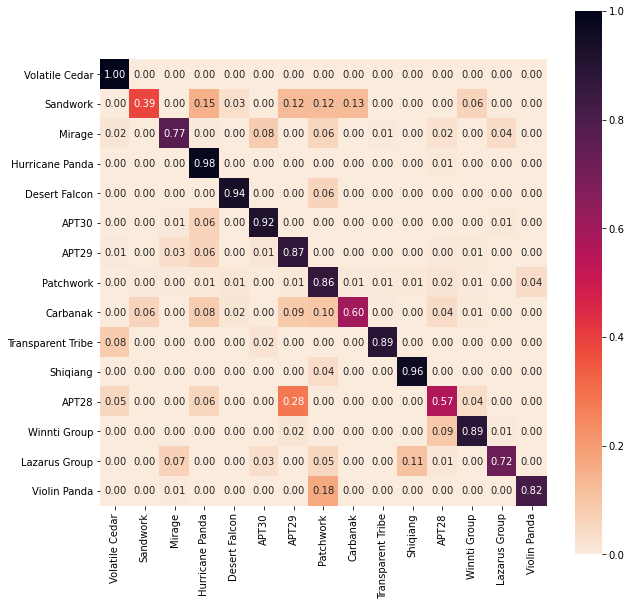

In [11]:
df_cm = pd.DataFrame(cnf, index=labels, columns=labels)
df_cm = df_cm.div(df_cm.sum(axis=1), axis=0)
fig = plt.figure(figsize=(10,10))
heatmap = sns.heatmap(df_cm, annot=True, fmt=".2f", square=True, cmap = sns.cm.rocket_r)
plt.savefig("confusion_matrix_cross_val_svm.png")

Here we can see the confusion matrix which is an average over the 5-fold cross validation tests. From the confusion matrix, we can see that there are specific APT groups on which the analyzed model performs badly, as is evident from the groups Violin Panda and APT28. Violin Panda is often mistaken with Patchwork. This result can be reduced to two reasons: first, looking at [8], this second APT group is known for reusing code from other sources; secondly, our dataset is unbalanced toward Patchwork. 
Another interesting case is about APT28 and APT29; both are attributed to Russia so, this is probably the reason why APT28 is confused with APT29.
Some of these results are comparable with the ones provided by [3]. However, as for other tasks, Gemini achieves poor results compared to SAFE.

Same results are also confirmed by the classification results reported below. Also in this case the reported results are an average over the 5-fold cross validation tests. According to F1-score, the worst performances are on Violin Panda and Carbanak, as shown in the confusion matrix.

In [12]:
report = pd.DataFrame(cum_report).T.round(3)

In [13]:
report

,precision,recall,f1-score,support
APT28,0.451,0.567,0.502,10.352
APT29,0.789,0.871,0.827,36.216
APT30,0.853,0.922,0.885,14.819
Carbanak,0.782,0.766,0.717,16.944
Desert Falcon,0.740,0.943,0.828,7.087
Hurricane Panda,0.861,0.984,0.918,54.262
Lazarus Group,0.932,0.729,0.814,15.470
Mirage,0.732,0.772,0.750,10.437
Patchwork,0.943,0.867,0.903,113.553
Sandwork,0.810,0.624,0.589,16.957


# Conclusions

Models for binary similarity are not malware/non-malware classifiers; they can be mostly considered as an help for the malware analyst during the real analysis and for this reason they are trained only with benign software. In this work, we have shown that even if the considered binary similarity model has been trained only on benign software to recognize similar functions, it can also provide us with helpful information about entire programs and malicious software. In conclusion, even if the results provided by our work are not comparable to malware classifiers, we believe that they are pretty interesting considering the original task the model was designed for.

# Bibliography

[1] S.H. Ding, B.C. Fung, and P. Charland. 2019. Asm2vec: Boosting static representation robustness for binary clone search against code obfuscation and compiler optimization. In 2019 IEEE Symposium on Security and Privacy (SP). IEEE, 472–489.  
[2] X. Xu, C. Liu, Q. Feng, H. Yin, L. Song, and D. Song. 2017. Neural network-based graph embedding for cross-platform binary code similarity detection. In Proceedings of the 2017 ACM SIGSAC Conference on Computer and Communications Security. 363–376.  
[3] L. Massarelli, G.A. Di Luna, F.Petroni, R. Baldoni, and L. Querzoni. 2019. Safe: Self-attentive function embeddings for binary similarity. In International Conference on Detection of Intrusions and Malware, and Vulnerability Assessment. 309-329. Springer, Cham.  
[4] Y. David, and E. Yahav. 2014. Tracelet-based code search in executables. In ACM SIGPLAN Conference on Programming Language Design and Implementation, PLDI. ACM, 349–360.  
[5] T.Dullien, and R.Rolles. Graph-based comparison of executable objects (english version). In Proceedings of Symposium sur la sécurité des technologies de l’information et des communications (SSTIC), Vol. 5. 3.  
[6] J. Pewny, F. Schuster, L. Bernhard, T. Holz, and C. Rossow. 2014. Leveraging semantic signatures for bug search in binary programs. In Proceedings of the 30th Annual Computer Security Applications Conference, ACSAC. ACM, 406–415.
[2] Y. Chen, E. K. Garcia, M. R. Gupta, A. Rahimi, and L. Cazzanti. 2009. Similarity-based classification: Concepts and algorithms. In Journal of Machine Learning Research 10.3. 747–776.  
[7]  G. Laurenza and R. Lazzeretti. dAPTaset: A comprehensive mapping of APT-related data. 2019. In Proc. 1st Int. Workshop Secur. Financial Critical Infrastructures Services. 217–225.   
[8] Mitre Att&ck Patchwork, https://attack.mitre.org/groups/G0040/